## Librarires and Data

In [1]:
import os
from itertools import chain

from sklearn.model_selection import GroupShuffleSplit

GRADIENT = os.path.exists('train')
KAGGLE = os.path.exists('../input')
model_name = 'baseline-model'
SEED = 42
VAL_PCT = 0.2

In [2]:
from fastai.vision.all import *

import gc

In [3]:
if KAGGLE:
    data_path = '../input/uw-madison-gi-tract-image-segmentation/'
elif GRADIENT:
    data_path = ''

In [4]:
path = Path(data_path+'train')
test_path = Path(data_path+'test')
train = pd.read_csv(data_path+'train.csv', low_memory=False)
fnames = get_image_files(path)

### Functions

In [5]:
# Extract case id from fname
def get_case_id(fname):
    if KAGGLE: i = 5
    elif GRADIENT: i = 2
    return fname.parts[i] + '_' + fname.parts[i+2][:10]

def check_file(file_id, fname):
    case_id, day, _, slice_no = file_id.split('_')
    if case_id == fname.parts[1] and day == fname.parts[2].split('_')[1] and slice_no in fname.parts[-1]:
        return True
    return False

def get_file(file_id):
    return fnames.filter(lambda f: check_file(not_null_train.id[0], f))[0]

# https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda
def get_custom_df(df, fnames, root):    
    # 1. Get Case-ID as a column (str and int)
    df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
    df["case_id"] = df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

    # 2. Get Day as a column
    df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
    df["day_num"] = df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))
    
    # Add case_day str column
    df["case_id_day_num_str"] = df["case_id_str"] + "_" + df["day_num_str"]

    # 3. Get Slice Identifier as a column
    df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])

    # 4. Get full file paths for the representative scans
    df["_partial_fname"] = (root+'/'+ # /kaggle/input/uw-madison-gi-tract-image-segmentation/train/
                          df["case_id_str"]+"/"+ # .../case###/
                          df["case_id_str"]+"_"+df["day_num_str"]+ # .../case###_day##/
                          "/scans/"+df["slice_id"]) # .../slice_####
    
    _tmp_merge_df = pd.DataFrame({"_partial_fname":[str(x).rsplit("_",4)[0] for x in fnames], "fname": fnames})
    df = df.merge(_tmp_merge_df, on="_partial_fname").drop(columns=["_partial_fname"])
    
    # Minor cleanup of our temporary workaround
    del _tmp_merge_df; gc.collect(); gc.collect()
    
    # 5. Get slice dimensions from filepath (int in pixels)
    df["slice_h"] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[1]))
    df["slice_w"] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[2]))

    # 6. Pixel spacing from filepath (float in mm)
    df["px_spacing_h"] = df["fname"].apply(lambda x: float(str(x)[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["fname"].apply(lambda x: float(str(x)[:-4].rsplit("_",4)[4]))

    # 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
    l_bowel_train_df = df[df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
    s_bowel_train_df = df[df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
    stomach_train_df = df[df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
    df = df.merge(l_bowel_train_df, on="id", how="left")
    df = df.merge(s_bowel_train_df, on="id", how="left")
    df = df.merge(stomach_train_df, on="id", how="left")
    df = df.drop_duplicates(subset=["id",]).reset_index(drop=True)
    df["lb_seg_flag"] = df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
    df["sb_seg_flag"] = df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
    df["st_seg_flag"] = df["st_seg_rle"].apply(lambda x: not pd.isna(x))
    df["n_segs"] = df["lb_seg_flag"].astype(int)+df["sb_seg_flag"].astype(int)+df["st_seg_flag"].astype(int)
    
    df = df.sort_values(by=['id']).copy()
    
    # Add 2.5D fnames
    channels=3
    stride=2
    for i in range(channels):
        df[f'fname_{i:02}'] = df.groupby(['case_id','day_num'])['fname'].shift(-i*stride).fillna(method="ffill")
    df['fnames'] = df[[f'fname_{i:02d}' for i in range(channels)]].values.tolist()

    # 8. Reorder columns to the a new ordering (drops class and segmentation as no longer necessary)
    df = df[["id", "fname", "fnames", "n_segs",
             "lb_seg_rle", "lb_seg_flag",
             "sb_seg_rle", "sb_seg_flag", 
             "st_seg_rle", "st_seg_flag",
             "slice_h", "slice_w", "px_spacing_h", 
             "px_spacing_w", "case_id_str", "case_id", 
             "day_num_str", "day_num", "case_id_day_num_str", "slice_id",]].reset_index(drop=True)
    

    return df

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

def get_image(row):
    img = np.array(Image.open(row['fname']))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img
    # return row['fname']
                   

def get_mask(row):
    mask = np.zeros((row['slice_w'], row['slice_h'], 3))
    if row['lb_seg_flag']:
        mask[..., 0] += rle_decode(row['lb_seg_rle'], shape=(row['slice_w'], row['slice_h']), color=255)
    if row['sb_seg_flag']:
        mask[..., 1] += rle_decode(row['sb_seg_rle'], shape=(row['slice_w'], row['slice_h']), color=255)
    if row['st_seg_flag']:
        mask[..., 2] += rle_decode(row['st_seg_rle'], shape=(row['slice_w'], row['slice_h']), color=255)
        
    return mask.astype(np.uint8)

def get_targs(row): return row[['lb_seg_flag', 'sb_seg_flag', 'st_seg_flag']].values.astype(np.uint8)

In [6]:
def add_custom_valid(train, val_pct):
    np.random.seed(SEED)

    cases = train.case_id.unique()
    n_cases = len(cases)
    random_cases = np.random.choice(cases, int(n_cases*val_pct/1.85), replace=False)

    train['is_valid'] = False
    train.loc[train.case_id.isin(random_cases), 'is_valid'] = True
    
    days = train.loc[~train['is_valid'], 'case_id_day_num_str'].unique()
    n_days = len(days)
    random_days = np.random.choice(days, int(n_days*val_pct/1.85), replace=False)

    train.loc[train.case_id_day_num_str.isin(random_days), 'is_valid'] = True
    
    return train

def add_group_valid(train, val_pct):
    gss = GroupShuffleSplit(n_splits=1, test_size=val_pct, random_state=SEED)
    train_idx, val_idx = [(train_idx, val_idx) for (train_idx, val_idx) in gss.split(train, train, train['case_id'])][0]

    train['is_valid'] = False
    train.loc[val_idx, 'is_valid'] = True

    return train

In [7]:
root = data_path+'test'
test_fnames = get_image_files(test_path)

if not test_fnames:
    test_fnames = fnames
    root = data_path+'train'

test = pd.DataFrame({
    'id': chain.from_iterable([[get_case_id(fname)]*3 for fname in test_fnames]),
    'class': chain.from_iterable([['large_bowel', 'small_bowel', 'stomach'] for _ in test_fnames]),
    'segmentation': chain.from_iterable([[np.nan]*3 for _ in test_fnames]),
})

test = get_custom_df(test, test_fnames, root)
train = get_custom_df(train, fnames, data_path+'train')

### DataBlock

In [8]:
@ToTensor
def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o))

@Normalize
def encodes(self, o:TensorMask): return o / 255

@Normalize
def decodes(self, o:TensorMask): 
    f = to_cpu if o.device.type=='cpu' else noop
    return f((o * 255).long())

In [9]:
import matplotlib.patches as mpatches

@typedispatch
def show_batch(x:TensorImage, y:TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        x_i = x[i] / x[i].max()
        show_image(x_i, ctx=ctx, cmap='gray', **kwargs)
        show_image(y[i], ctx=ctx, cmap='Spectral_r', alpha=0.35, **kwargs)
        red_patch = mpatches.Patch(color='red', label='lb')
        green_patch = mpatches.Patch(color='green', label='sb')
        blue_patch = mpatches.Patch(color='blue', label='st')
        ctx.legend(handles=[red_patch, green_patch, blue_patch], fontsize=figsize[0]/2)

In [10]:
from scipy.spatial.distance import directed_hausdorff

def mod_acc(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != 0
    if mask.sum() == 0:
        mask = targ == 0
    return (torch.where(sigmoid(inp) > 0.5, 1, 0)[mask]==targ[mask]).float().mean().item()

def dice_coeff(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    eps = 1e-5
    I = (targ * inp).sum((2, 3))
    U =  targ.sum((2,3)) + inp.sum((2, 3))
    return ((2.*I+eps)/(U+eps)).mean((1, 0))

# def dice_coeff(inp, targ):
#     if torch.is_tensor(inp):
#         inp = torch.where(sigmoid(inp) > 0.5, 1, 0).cpu().detach().numpy().astype(np.uint8)
#     if torch.is_tensor(targ):
#         targ = targ.cpu().detach().numpy().astype(np.uint8)
#     # mask = targ == 1
#     # I = (inp[mask] == targ[mask]).sum((2, 3))
#     eps = 1e-5
#     I = (targ & inp).sum((2, 3))
#     # U = inp.sum((2, 3)) + targ.sum((2, 3))
#     U = (targ | inp).sum((2, 3))
#     return ((2*I)/(U+I+1) + (U==0)).mean((1, 0))

# def dice_coeff2(inp, targ, thr=0.5, dim=(2,3), epsilon=0.001):
#     targ = targ.to(torch.float32)
#     inp = (inp>thr).to(torch.float32)
#     inter = (targ*inp).sum(dim=dim)
#     den = targ.sum(dim=dim) + inp.sum(dim=dim)
#     dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
#     return dice

def hd_dist_per_slice(inp, targ):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    # if len(targ) == 0:
    #     inp = 1 - inp
    #     targ = 1 - targ
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    
    return np.mean([np.mean([hd_dist_per_slice(inp[i, j], targ[i, j]) for j in range(3)]) for i in range(len(inp))])

def custom_metric(inp, targ):
    hd_score_per_batch = hd_dist(inp, targ)
    dice_score_per_batch = dice_coeff(inp, targ)
        
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

def dice_loss(inp, targ, eps=1e-5, reduction='sum'):
    inp = TensorBase(torch.where(sigmoid(inp) > 0.5, 1, 0).to(torch.float32))
    targ = TensorBase(targ.to(torch.float32))
    inter = (targ*inp).sum(dim=(2, 3))
    den = targ.sum(dim=(2, 3)) + inp.sum(dim=(2, 3))
    dice = ((2.*inter+eps)/(den+eps))
    if reduction == 'sum': return dice.sum()
    if reduction == 'mean': return dice.mean()



def custom_loss(inp, targ):
    return nn.BCEWithLogitsLoss()(inp, targ.float())

In [11]:
def post_process(inp):
    inp[np.where(inp.sum((2, 3)) < [11, 29, 12])] = 0 
    return inp

def dice_coeff_adj(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0
    
    
def hd_dist_per_slice(inp, targ):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    # if len(targ) == 0:
    #     inp = 1 - inp
    #     targ = 1 - targ
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist_adj(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric_adj(inp, targ):
    hd_score_per_batch = hd_dist_adj(inp, targ)
    dice_score_per_batch = dice_coeff_adj(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

In [12]:
class DiceBCEModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5]):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*bce_loss
    
class DiceBCELoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], thresh=0.5, **kwargs):
        super().__init__(DiceBCEModule, *args, eps=eps, from_logits=from_logits, ws=ws, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [13]:
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class DiceFocalModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            inp = torch.sigmoid(inp)
                
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss
    
class DiceFocalLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(DiceFocalModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [14]:
class FocalTverskyLossModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            inp = torch.sigmoid(inp)
            
        inp_0, inp_1 = inp, 1 - inp
        targ_0, targ_1 = targ, 1 - targ
            
        num = (inp_0 * targ_0).sum() 
        denom = num + (self.alpha * (inp_0 * targ_1).sum()) + (self.beta * (inp_1 * targ_0).sum()) + self.eps
        loss = 1 - (num / denom)
        return loss**self.gamma 
    
class FocalTverskyLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4, thresh=0.5, **kwargs):
        super().__init__(FocalTverskyLossModule, *args, eps=eps, from_logits=from_logits, alpha=alpha, beta=beta, gamma=gamma, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [15]:
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class ComboModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
                
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss + self.ws[2]*bce_loss
    
class ComboLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(ComboModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [16]:
import segmentation_models_pytorch as smp
import albumentations

In [17]:
def load_image(fname):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img

def get_25D_image(row):
    imgs = np.zeros((row['slice_w'], row['slice_h'], len(row['fnames'])))
    for i, fname in enumerate(row['fnames']):
        img = load_image(fname)
        imgs[..., i]+=img
    return imgs.astype(np.uint8)

def get_25D_dls(df, img_size=224, method='squish', aug='albumentations', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df
    
    tfms = [[get_25D_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    
    if aug == 'albumentations':
        after_item = [Resize(img_size, method=method),
                             SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                             ToTensor()]
        after_batch = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
        
    elif aug == 'fastai':
        after_item = [Resize(img_size, method=method),ToTensor()]
        after_batch = [IntToFloatTensor, *aug_transforms(), Normalize.from_stats(*imagenet_stats)]
    
    dls = dsets.dataloaders(bs=bs, after_item=after_item, after_batch=after_batch)
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

In [18]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
class AlbumentationsTransform(DisplayedTransform):
    order = 2
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x: PILImage):
        aug = self.aug(image=np.array(x))
        return PILImage.create(aug["image"])
    

def get_train_aug(img_size):
    if isinstance(img_size, int): img_size = (img_size, img_size)
    return albumentations.Compose([
            albumentations.HorizontalFlip(p=0.5),
            albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            albumentations.CoarseDropout(max_holes=8, max_height=img_size[0]//20, max_width=img_size[1]//20,
                             min_holes=5, fill_value=0, mask_fill_value=0, p=0.5)
    ])

def get_dls(df, img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df.sample(frac=1.0, random_state=SEED)
    
    tfms = [[get_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=[Resize(img_size, method=method),
                                               SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                                               ToTensor()],
                           after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

In [19]:
def get_aug_dls(df, aug=[], img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    if aug: batch_tfms = [*aug] + batch_tfms
    
    db = DataBlock((ImageBlock(cls=PILImageBW), MaskBlock),
                   get_x=get_image,
                   get_y=get_mask,
                   splitter = ColSplitter(),
                   item_tfms=[Resize(img_size, method=method)],
                   batch_tfms=batch_tfms)
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df.sample(frac=1.0, random_state=SEED)
        
        
    dls = db.dataloaders(dev, bs=bs, shuffle=True)
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

def build_model(encoder_name):
    model = smp.Unet(
        encoder_name=encoder_name,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to('cuda')
    return model


def unet_splitter(model):
    model_layers = list(model.children())
    encoder_params = params(model_layers[0])
    decoder_params = params(model_layers[1]) + params(model_layers[2])
    return L(encoder_params, decoder_params)

def dynamic_unet_splitter(model):
    return L(model[0], model[1:]).map(params)

def cat_splitter(model): return L(model.body, model.head).map(params)

def get_learner(dls, arch, loss_func, seed=SEED, **kwargs):
    set_seed(seed, True)
    learn = unet_learner(dls, arch, metrics=[mod_acc, dice_coeff, hd_dist, custom_metric], n_out=3, loss_func=loss_func, **kwargs).to_fp16()
    return learn

def get_custom_learner(dls, model, loss_func, splitter, seed=SEED, **kwargs):
    set_seed(seed, True)
    learn = Learner(dls, model, metrics=[dice_coeff_adj, hd_dist_adj, custom_metric_adj], loss_func=loss_func, splitter=splitter, **kwargs).to_fp16()
    learn.freeze()
    return learn

#### Dynamic Timm Unet

In [20]:
import timm

def timm_model_sizes(encoder, img_size):
    sizes = []
    for layer in encoder.feature_info:
        sizes.append(torch.Size([1, layer['num_chs'], img_size[0]//layer['reduction'], img_size[1]//layer['reduction']]))
    return sizes


def get_timm_output_layers(encoder):
    outputs = []
    for layer in encoder.feature_info:
        # Converts 'blocks.0.0' to ['blocks', '0', '0']
        attrs = layer['module'].split('.')
        output_layer = getattr(encoder, attrs[0])[int(attrs[1])][int(attrs[2])]
        outputs.append(output_layer)
    return outputs


class DynamicTimmUnet(SequentialEx):
    "Create a U-Net from a given architecture in timm."
    def __init__(self, encoder, n_out, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = timm_model_sizes(encoder, img_size)
        sz_chg_idxs = list(reversed(range(len(sizes))))
        outputs = list(reversed(get_timm_output_layers(encoder)))
        self.sfs = hook_outputs(outputs, detach=False)
        
        # cut encoder
        encoder = nn.Sequential(*list(encoder.children()))[:-5]
        
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        layers += [ConvLayer(ni, n_out, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        #apply_init(nn.Sequential(layers[2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        layers.append(ToTensorBase())
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
        
        
class CatModel(nn.Module):
    def __init__(self, body, head):
        super(CatModel, self).__init__()
        self.body = body
        self.head = head
    def forward(self, x):
        return self.head(self.body(x))

## Progressive resizing

In [21]:
img_size = [320, 384]
hf_img_size = [sz//2 for sz in img_size]

In [22]:
hf_img_size

[160, 192]

In [23]:
dls, dev = get_25D_dls(train, img_size=hf_img_size, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [24]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

In [25]:
learn.fit_one_cycle(5, 3e-2)

In [26]:
dls, dev = get_25D_dls(train, img_size=img_size, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [27]:
learn.dls = dls

In [28]:
learn.fit_one_cycle(5, 3e-2)

### Without

In [23]:
dls, dev = get_25D_dls(train, img_size=img_size, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [24]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

## Unet#

In [21]:
class UNetBlock(nn.Module):
    def __init__(self, ni, nf, final_div=True, blur=False, act_cls=defaults.activation,
                 self_attention=False, init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        super().__init__()
        self.conv1 = ConvLayer(ni, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.conv2 = ConvLayer(nf, nf, act_cls=act_cls, norm_type=norm_type,
                               xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = act_cls()
        apply_init(nn.Sequential(self.conv1, self.conv2), init)
        
    def forward(self, x):
        return self.conv2(self.conv1(x))

class UNetDashDecoder(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        self.sizes = sizes
        
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.up8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.up16 = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)
        
        self.unet0_1 = UNetBlock(self.sizes[0]+self.sizes[1], self.sizes[0])
        self.unet1_1 = UNetBlock(self.sizes[1]+self.sizes[2], self.sizes[1])
        self.unet2_1 = UNetBlock(self.sizes[2]+self.sizes[3], self.sizes[2])
        self.unet3_1 = UNetBlock(self.sizes[3]+self.sizes[4], self.sizes[3])
        
        self.unet0_2 = UNetBlock(2*self.sizes[0]+self.sizes[1]+self.sizes[2], self.sizes[0])
        self.unet1_2 = UNetBlock(2*self.sizes[1]+self.sizes[2]+self.sizes[3], self.sizes[1])
        self.unet2_2 = UNetBlock(2*self.sizes[2]+self.sizes[3]+self.sizes[4], self.sizes[2])
        
        self.unet0_3 = UNetBlock(3*self.sizes[0]+self.sizes[1]+self.sizes[2]+self.sizes[3], self.sizes[0])
        self.unet1_3 = UNetBlock(3*self.sizes[1]+self.sizes[2]+self.sizes[3]+self.sizes[4], self.sizes[1])
        
        self.unet0_4 = UNetBlock(4*self.sizes[0]+self.sizes[1]+self.sizes[2]+self.sizes[3]+self.sizes[4], self.sizes[0])

        
        
    def forward(self, x0_0, x1_0, x2_0, x3_0, x4_0):
        x0_1 = self.unet0_1(torch.cat([x0_0, self.up2(x1_0)], 1))
        x1_1 = self.unet1_1(torch.cat([x1_0, self.up2(x2_0)], 1))
        x2_1 = self.unet2_1(torch.cat([x2_0, self.up2(x3_0)], 1))
        x3_1 = self.unet3_1(torch.cat([x3_0, self.up2(x4_0)], 1))
        
        x0_2 = self.unet0_2(torch.cat([x0_0, x0_1, self.up2(x1_1), self.up4(x2_0)], 1))
        x1_2 = self.unet1_2(torch.cat([x1_0, x1_1, self.up2(x2_1), self.up4(x3_0)], 1))
        x2_2 = self.unet2_2(torch.cat([x2_0, x2_1, self.up2(x3_1), self.up4(x4_0)], 1))
        
        x0_3 = self.unet0_3(torch.cat([x0_0, x0_1, x0_2, self.up2(x1_2), self.up4(x2_1), self.up8(x3_0)], 1))
        x1_3 = self.unet1_3(torch.cat([x1_0, x1_1, x1_2, self.up2(x2_2), self.up4(x3_1), self.up8(x4_0)], 1))
                                            
        x0_4 = self.unet0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up2(x1_3), self.up4(x2_2), self.up8(x3_1), self.up16(x4_0)], 1))
        
        return x0_1, x0_2, x0_3, x3_1, x2_2, x1_3, x0_4
        
        

class UNetDash(nn.Module):
    def __init__(self, encoder, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        self.encoder = encoder
        self.sizes = [size[1] for size in timm_model_sizes(encoder, (224, 224))]
        self.decoder = UNetDashDecoder(self.sizes)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.up8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.up16 = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=True)
        
        if self.deep_supervision:
            final_in = 4*self.sizes[0]+self.sizes[1]+self.sizes[2]+self.sizes[3]
        else:
            final_in = self.sizes[0]
            
        self.final = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'), 
                                   ConvLayer(final_in, final_in//2, ks=1, act_cls=None, norm_type=None),
                                   ConvLayer(final_in//2, 3, ks=1, act_cls=None, norm_type=None))     
        
    def forward(self, x):
        x0_0, x1_0, x2_0, x3_0, x4_0 = self.encoder(x)
        x0_1, x0_2, x0_3, x3_1, x2_2, x1_3, x0_4 = self.decoder(x0_0, x1_0, x2_0, x3_0, x4_0)
        
        if self.deep_supervision:
            return self.final(torch.cat([x0_1, x0_2, x0_3, self.up8(x3_1), self.up4(x2_2), self.up2(x1_3), x0_4], 1))
        else:
            return self.final(x0_4)

In [22]:
unet = UNetDash(timm.create_model('efficientnet_b0', features_only=True), deep_supervision=False)

In [23]:
def splitter(model):
    return L(model.encoder, model.decoder, model.final).map(params)

In [24]:
dls, dev = get_25D_dls(train, img_size=(320, 384), aug='albumentations', sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [25]:
learn = get_custom_learner(dls, unet, ComboLoss(), splitter)

SuggestedLRs(valley=0.00363078061491251)

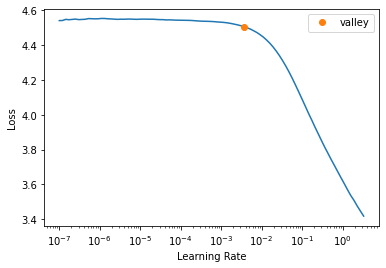

In [32]:
learn.lr_find()

In [26]:
learn.fit_flat_cos(10, 0.1)

In [ ]:
learn.show_results()

## Large Image Sizes

I'll use the latest test in CLAHE as a reference score and will go on and test.

### Implemenetation

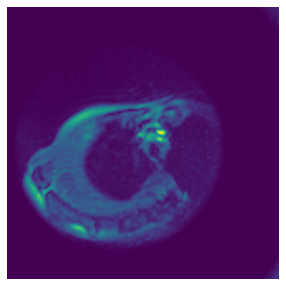

In [68]:
img = PILImage.create(get_image(train.iloc[0]))
img.show();

In [71]:
rsz = Resize(size=(320,384), method='squish')
rsz_img = rsz(img)

In [73]:
rsz_img.shape

(320, 384)

### Test

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


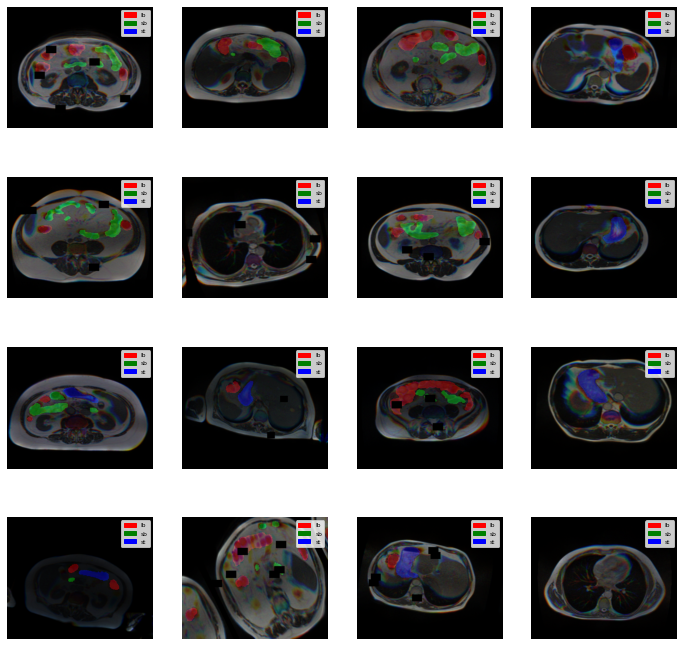

In [21]:
dls, dev = get_25D_dls(train, img_size=(320, 384), method='squish', sample=True, sample_empty=True)

In [22]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), FocalTverskyLoss(), unet_splitter)

In [23]:
learn.fit_one_cycle(5, 3e-2)

## Adding CLAHE

### Control

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


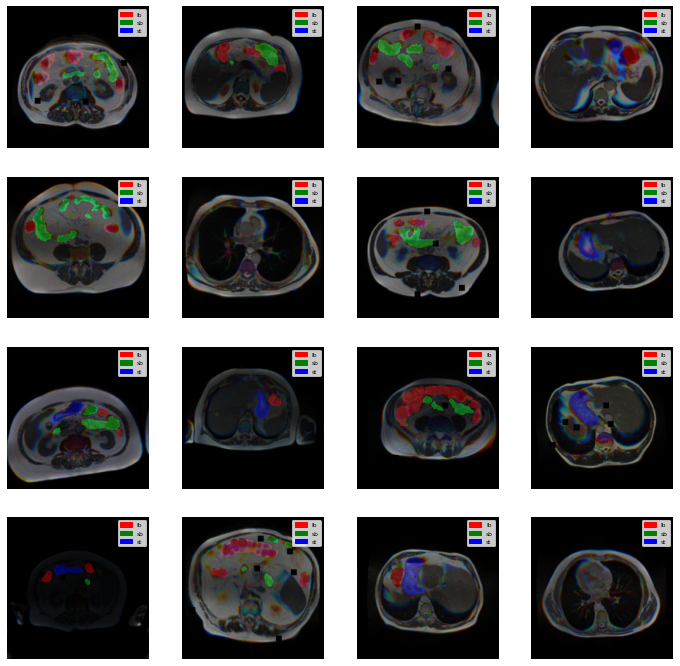

In [136]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True)

In [137]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [138]:
learn.fit_one_cycle(5, 3e-2)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


### Test

In [21]:
def get_image(row):
    img = np.array(Image.open(row['fname']))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    img = albumentations.CLAHE()(image=get_image(train.iloc[i]).astype(np.uint8))['image']
    return img

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


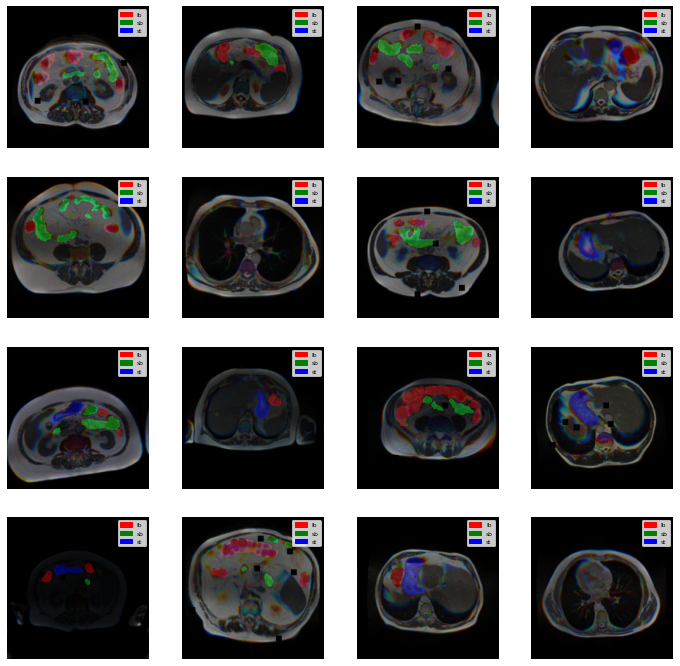

In [22]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True)

In [23]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

In [24]:
learn.fit_one_cycle(5, 3e-2)

KeyboardInterrupt: 

## Combo BCE + Focal Loss + Dice

In [20]:
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class ComboModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
                
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss + self.ws[2]*bce_loss
    
class ComboLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(ComboModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [33]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [34]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), ComboLoss(), unet_splitter, opt_func=ranger)

SuggestedLRs(valley=0.019054606556892395)

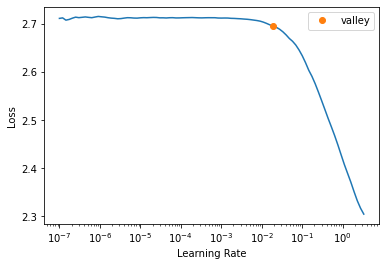

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(10, 3e-2)

### Try different weights

In [21]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [22]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), ComboLoss(ws=[2, 3, 1]), unet_splitter, opt_func=ranger)

In [23]:
learn.fit_one_cycle(10, 3e-2)

Combo Loss is a total killer, let's try it with Unet++

In [22]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [23]:
learn = get_custom_learner(dls, build_unet_pp('efficientnet-b1'), ComboLoss(ws=[2, 3, 1]), unet_splitter, opt_func=ranger)

In [24]:
learn.fit_one_cycle(10, 3e-2)

## Unet++

In [21]:
def build_unet_pp(encoder_name):
    model = smp.UnetPlusPlus(
        encoder_name=encoder_name,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to('cuda')
    return model

### Control

In [21]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [22]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [23]:
learn.fit_one_cycle(10, 3e-2)

### Test

In [21]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [22]:
learn = get_custom_learner(dls, build_unet_pp('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [23]:
learn.fit_one_cycle(10, 3e-2)

## Progressive resizing

### Control

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


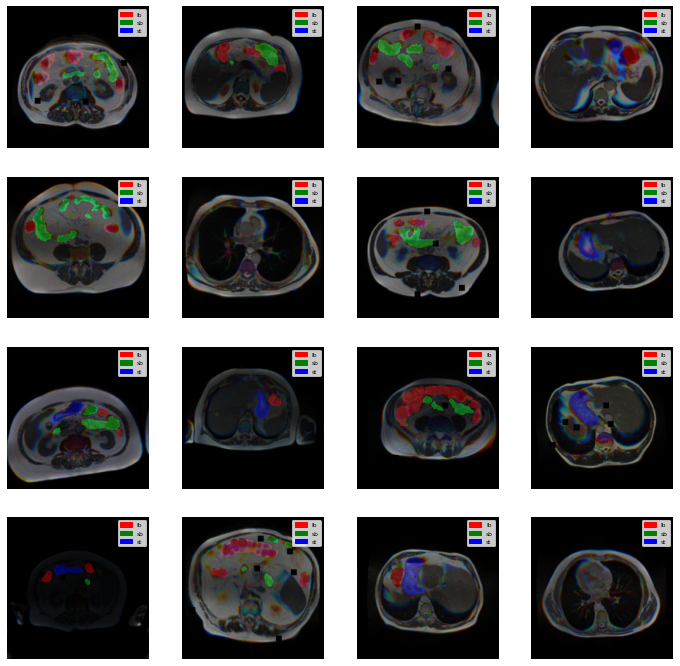

In [20]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=True)

In [21]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [22]:
lr = 3e-2

In [23]:
learn.fit_one_cycle(10, lr)

In [24]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/400, lr/4))

### Test

In [20]:
dls, dev = get_25D_dls(train, img_size=128, aug='albumentations', sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [21]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

SuggestedLRs(valley=0.010964781977236271)

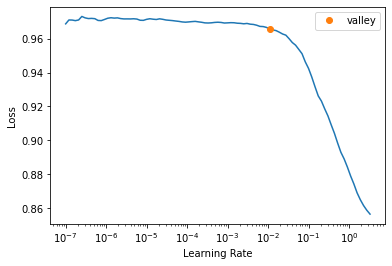

In [22]:
learn.lr_find()

In [23]:
lr = 3e-2

In [24]:
learn.fit_one_cycle(5, lr)

In [25]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/400, lr/4))

In [26]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [27]:
dls, dev = get_25D_dls(train, img_size=224, aug='albumentations', sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [29]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [30]:
learn.load('stage-1')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00363078061491251)

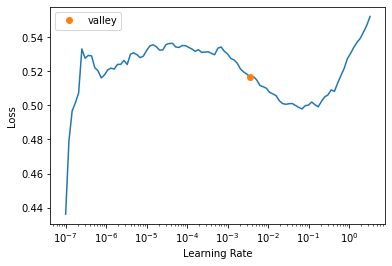

In [31]:
learn.lr_find()

In [32]:
lr = 4e-3

In [33]:
learn.fit_one_cycle(5, lr)

In [34]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/400, lr/4))

## Use random crops 

### Control

In [20]:
def get_25D_dls(df, img_size=224, method='squish', aug='albumentations', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df
    
    tfms = [[get_25D_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    
    if aug == 'albumentations':
        after_item = [Resize(img_size, method=method),
                             SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                             ToTensor()]
        after_batch = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
        
    elif aug == 'fastai':
        after_item = [Resize(266, method='pad'),ToTensor()]
        after_batch = [IntToFloatTensor, *aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats)]
    
    dls = dsets.dataloaders(bs=bs, after_item=after_item, after_batch=after_batch)
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


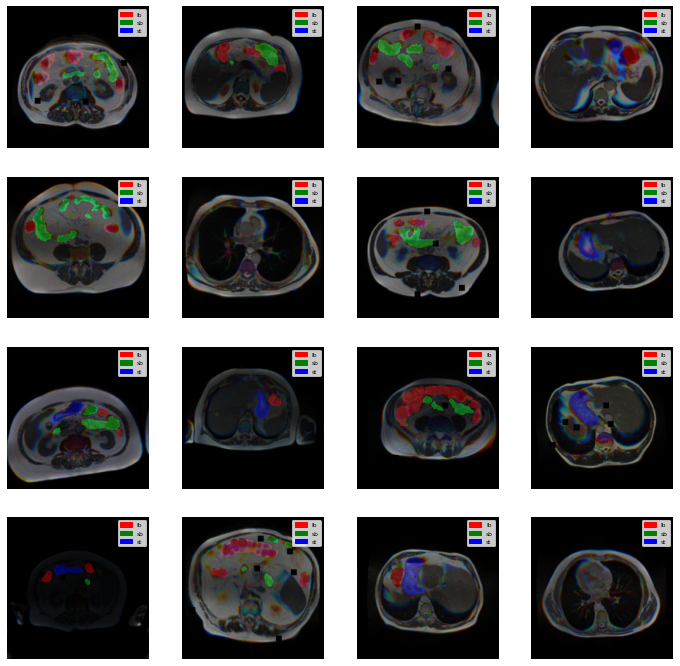

In [21]:
dls, dev = get_25D_dls(train, aug='albumentations', sample=True, sample_empty=True, show=True)

In [22]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [23]:
learn.fit_one_cycle(5, 3e-2)

### Test

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


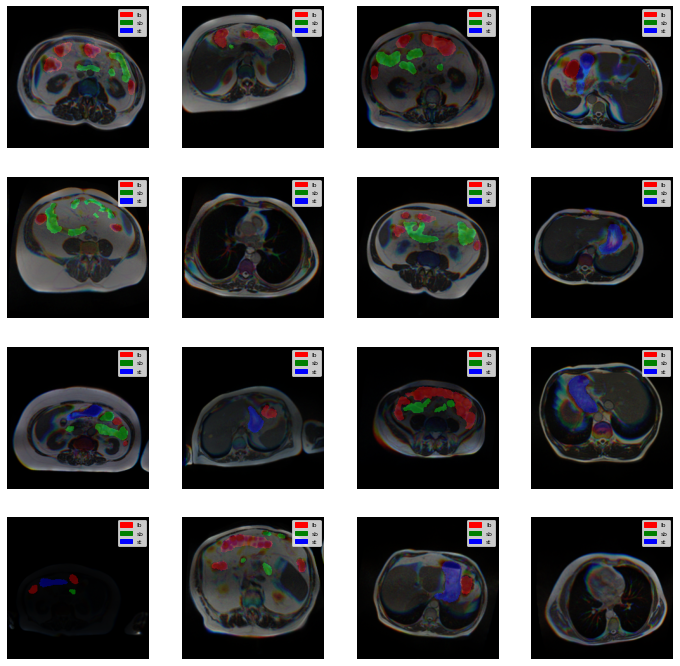

In [24]:
dls, dev = get_25D_dls(train, aug='fastai', sample=True, sample_empty=True, show=True)

In [25]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), FocalTverskyLoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(5, 3e-2)

## Use Tversky Loss

In [19]:
class TverskyLossModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            inp = torch.sigmoid(inp)
            
        inp_0, inp_1 = inp, 1 - inp
        targ_0, targ_1 = targ, 1 - targ
            
        num = (inp_0 * targ_0).sum() 
        denom = num + (self.alpha * (inp_0 * targ_1).sum()) + (self.beta * (inp_1 * targ_0).sum()) + self.eps
        loss = 1 - (num / denom)
        return loss**self.gamma 
    
class TverskyLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4, thresh=0.5, **kwargs):
        super().__init__(TverskyLossModule, *args, eps=eps, from_logits=from_logits, alpha=alpha, beta=beta, gamma=gamma, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

### Control

In [20]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [21]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), DiceFocalLoss(), unet_splitter, opt_func=ranger)

In [22]:
learn.fit_one_cycle(10, 3e-2)

### Test

In [23]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [24]:
learn = get_custom_learner(dls, build_model('efficientnet-b1'), TverskyLoss(), unet_splitter, opt_func=ranger)

In [25]:
learn.fit_one_cycle(10, 3e-2)

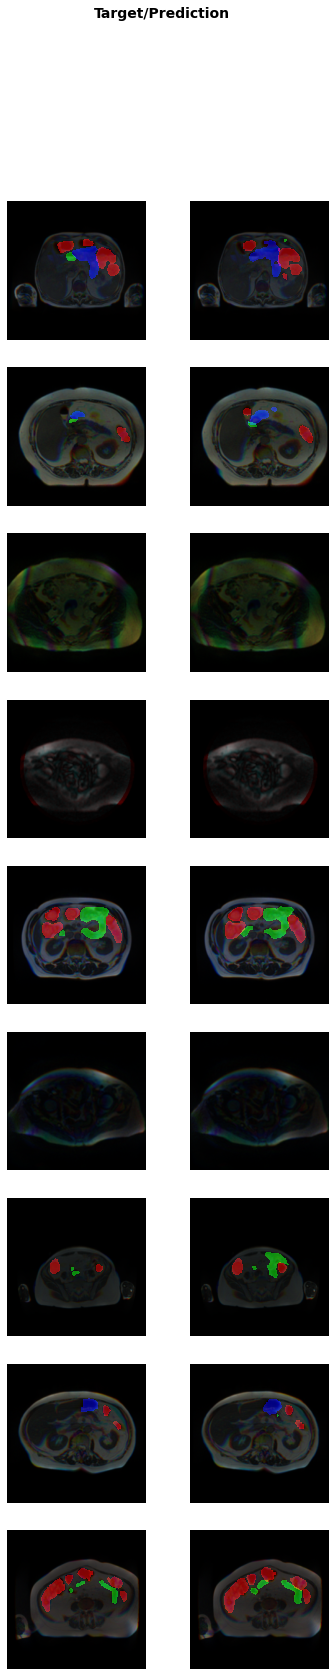

In [26]:
learn.show_results()

In [27]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [28]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), TverskyLoss(gamma=1), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_one_cycle(10, 3e-2)

## Use Focal Loss

In [50]:
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class DiceFocalModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss
    
class DiceFocalLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(DiceFocalModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

### Baseline

In [ ]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

In [ ]:
unet = build_model('efficientnet-b1')

In [ ]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter)

In [55]:
learn.fit_one_cycle(10, 2e-2)

### Test

In [42]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [43]:
unet = build_model('efficientnet-b1')

In [44]:
learn = get_custom_learner(dls, unet, DiceFocalLoss(), unet_splitter)

In [45]:
learn.fit_one_cycle(10, 2e-2)

Now I know that it's better, but let's test removing the multiplier of focal loss.

In [51]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [52]:
unet = build_model('efficientnet-b1')

In [53]:
learn = get_custom_learner(dls, unet, DiceFocalLoss(n=1), unet_splitter)

In [54]:
learn.fit_one_cycle(10, 2e-2)

I want to try my dynamic model for the last time.

In [20]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [28]:
encoder = timm.create_model('efficientnet_b1', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224), self_attention=True)

In [29]:
learn = get_custom_learner(dls, unet, DiceFocalLoss(), dynamic_unet_splitter)

SuggestedLRs(valley=6.30957365501672e-05)

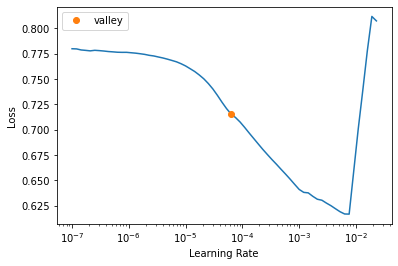

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(10, 2e-3)

Another time without self attention

In [32]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [33]:
encoder = timm.create_model('efficientnet_b1', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [34]:
learn = get_custom_learner(dls, unet, DiceFocalLoss(), dynamic_unet_splitter)

In [35]:
learn.fit_one_cycle(10, 2e-3)

## Use 2.5 Data

### Baseline

In [17]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [18]:
# encoder = timm.create_model('efficientnet_b0', pretrained=True)
# unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

unet = build_model('efficientnet-b1')

In [19]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter)

In [20]:
learn.fit_one_cycle(3, 2e-2)

### Test

#### Implementation

In [21]:
channels=3
stride=2
for i in range(channels):
    train[f'fname_{i:02}'] = train.groupby(['case_id','day_num'])['fname'].shift(-i*stride).fillna(method="ffill")
train['fnames'] = train[[f'fname_{i:02d}' for i in range(channels)]].values.tolist()
train.fnames[0]

[Path('train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'),
 Path('train/case123/case123_day20/scans/slice_0003_266_266_1.50_1.50.png'),
 Path('train/case123/case123_day20/scans/slice_0005_266_266_1.50_1.50.png')]

In [24]:
def load_image(fname):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0,255])
    return img

def get_25D_image(row):
    imgs = np.zeros((row['slice_w'], row['slice_h'], len(row['fnames'])))
    for i, fname in enumerate(row['fnames']):
        img = load_image(fname)
        imgs[..., i]+=img
    return imgs.astype(np.uint8)

def get_25D_dls(df, img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df
    
    tfms = [[get_25D_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=[Resize(img_size, method=method),
                                               SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                                               ToTensor()],
                           after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


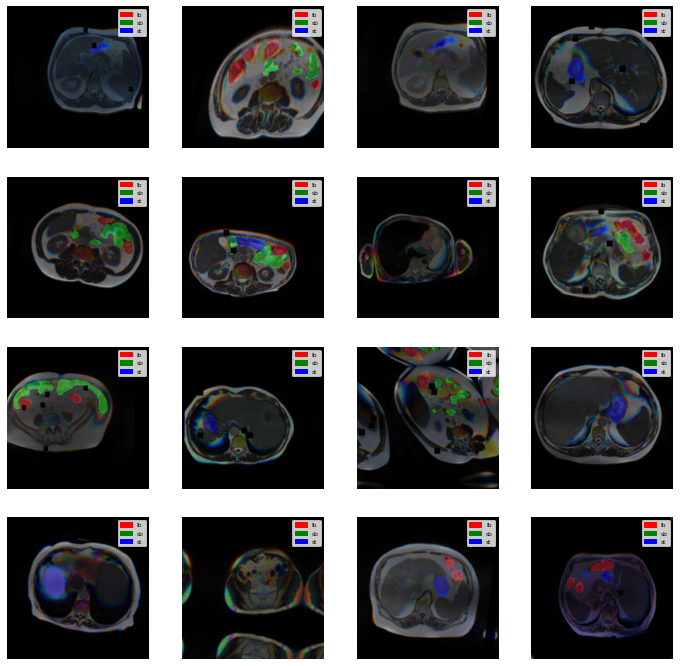

In [39]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=True)

In [40]:
# encoder = timm.create_model('efficientnet_b0', pretrained=True)
# unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

unet = build_model('efficientnet-b1')

In [41]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter)

In [42]:
learn.fit_one_cycle(10, 2e-2)

### Dynamic

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


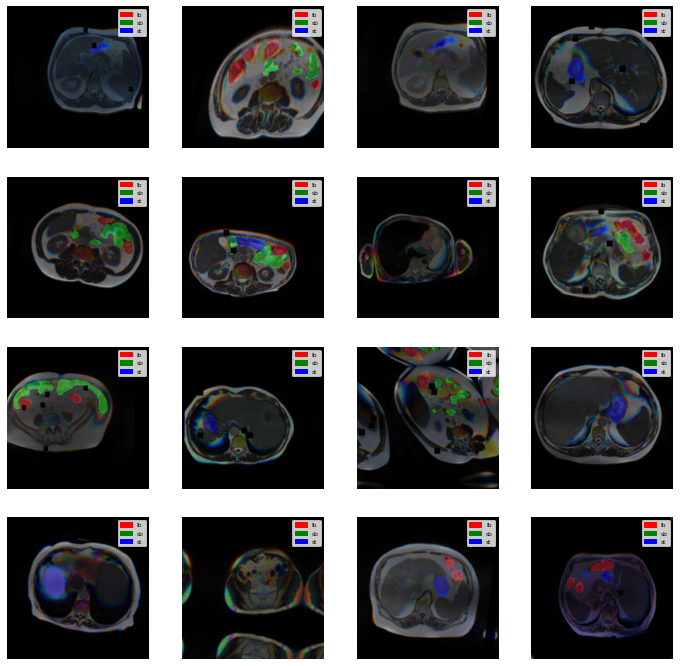

In [43]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=True)

In [44]:
encoder = timm.create_model('efficientnet_b1', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224), self_attention=True)

In [45]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), dynamic_unet_splitter)

In [46]:
learn.fit_one_cycle(10, 1e-3)

In [47]:
dls, dev = get_25D_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [48]:
encoder = timm.create_model('efficientnet_b1', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224), self_attention=True)

In [49]:
learn.fit_one_cycle(10, 2e-2)

## Compare training encoder on category task first

### Baseline

In [190]:
dls, dev = get_dls(train, sample=True, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [191]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [192]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), dynamic_unet_splitter)

In [193]:
learn.fit_one_cycle(3, 1e-3)

### Test

In [194]:
dls, dev = get_dls(train, sample=True, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [195]:
def get_cat_dls(df, img_size=224, method='squish'):
    db = DataBlock((ImageBlock(cls=PILImageBW), MultiCategoryBlock(encoded=True, vocab={'lb': 0, 'sb': 1, 'st': 2})),
               get_x=get_image,
               get_y=get_targs,
               splitter = ColSplitter(),
               item_tfms=[Resize(img_size, method=method), AlbumentationsTransform(get_train_aug(img_size), 0)],
               batch_tfms=[Normalize.from_stats(*imagenet_stats)])
    
    set_seed(SEED, True)
    return db.dataloaders(df, bs=16, shuffle=True)

In [196]:
cat_dls = get_cat_dls(dev)

In [197]:
def get_cat_model(unet):
    body = nn.Sequential(*encoder.children())[:-2]
    head = create_head(1280, 3)
    return CatModel(body, head)

In [198]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))
cat_model = get_cat_model(unet)

In [199]:
cat_learn = Learner(cat_dls, cat_model, BCEWithLogitsLossFlat(), splitter=cat_splitter, metrics=accuracy_multi)

SuggestedLRs(valley=0.0003311311302240938)

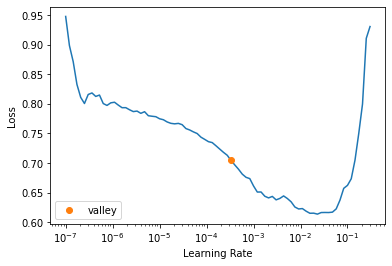

In [172]:
cat_learn.lr_find()

In [200]:
cat_learn.fine_tune(5, 1e-4)

In [201]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), dynamic_unet_splitter)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=4.365158383734524e-05)

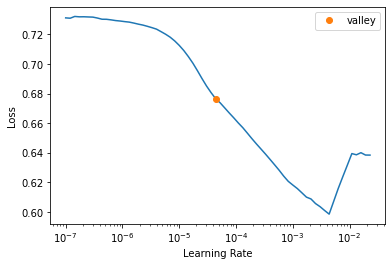

In [175]:
learn.lr_find()

In [202]:
learn.fit_one_cycle(3, 1e-3)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Didn't improve performance, so I'll drop it.

## Compare my dynamic unet with smp's unet

### Dynamic Timm Unet

In [138]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [139]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [143]:
def dynamic_unet_splitter(model):
    return L(model[0], model[1:]).map(params)

In [144]:
learn = get_custom_learner(dls, unet, DiceBCELoss(), dynamic_unet_splitter)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00010964782268274575)

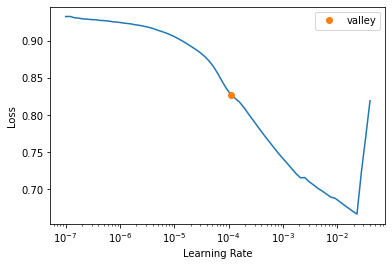

In [145]:
learn.lr_find()

In [147]:
learn.fit_one_cycle(5, 1e-3)

### SMP's unet

In [151]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [152]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

SuggestedLRs(valley=0.00363078061491251)

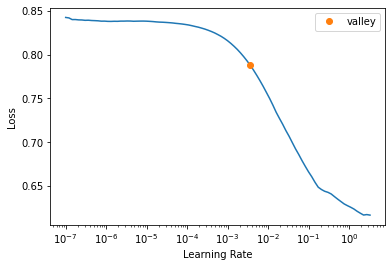

In [153]:
learn.lr_find()

In [154]:
learn.fit_one_cycle(5, 2e-2)

Mine is better.

## Test training encoder first

### Implementation

#### Create model and isolate encoder (Failed)

In [22]:
unet = build_model('efficientnet-b0')

In [17]:
body = create_body(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [38]:
body = nn.Sequential(*unet.encoder.children())
head = create_head(1280, 3)

class CustomModel(nn.Module):
    def __init__(self, body, head):
        super(CustomModel, self).__init__()
        self.body = body
        self.head = head
    def forwards(self, x):
        return self.head(self.body(x))

In [48]:
type(unet.encoder)

segmentation_models_pytorch.encoders.efficientnet.EfficientNetEncoder

In [57]:
unet.encoder

EfficientNetEncoder(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [65]:
unet.encoder(torch.zeros((1, 3, 224, 224)).cuda())[0].shape

torch.Size([1, 3, 224, 224])

In [24]:
body = TimmBody('efficientnet_b0')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [140]:
cat_model = CustomModel(body, head)

#### Create dynamic unet using timm and fastai

In [68]:
import timm

def timm_model_sizes(encoder, img_size):
    sizes = []
    for layer in encoder.feature_info:
        sizes.append(torch.Size([1, layer['num_chs'], img_size[0]//layer['reduction'], img_size[1]//layer['reduction']]))
    return sizes


def get_timm_output_layers(encoder):
    outputs = []
    for layer in encoder.feature_info:
        # Converts 'blocks.0.0' to ['blocks', '0', '0']
        attrs = layer['module'].split('.')
        output_layer = getattr(encoder, attrs[0])[int(attrs[1])][int(attrs[2])]
        outputs.append(output_layer)
    return outputs


class DynamicTimmUnet(SequentialEx):
    "Create a U-Net from a given architecture in timm."
    def __init__(self, encoder, n_out, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = timm_model_sizes(encoder, (224, 224))
        sz_chg_idxs = list(reversed(range(len(sizes))))
        outputs = list(reversed(get_timm_output_layers(encoder)))
        self.sfs = hook_outputs(outputs, detach=False)
        
        # cut encoder
        encoder = nn.Sequential(*list(encoder.children()))[:-5]
        
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        layers += [ConvLayer(ni, n_out, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        #apply_init(nn.Sequential(layers[2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        layers.append(ToTensorBase())
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [74]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [97]:
body = nn.Sequential(*encoder.children())[:-2]
head = create_head(1280, 3)

class CatModel(nn.Module):
    def __init__(self, body, head):
        super(CatModel, self).__init__()
        self.body = body
        self.head = head
    def forward(self, x):
        return self.head(self.body(x))

In [98]:
cat_model = CatModel(body, head)

In [99]:
dummy_eval(cat_model, (224, 224)).shape

torch.Size([1, 3])

#### Create dataset

In [100]:
def get_targs(row): return row[['lb_seg_flag', 'sb_seg_flag', 'st_seg_flag']].values.astype(np.uint8)

In [101]:
mask_dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [102]:
class AlbumentationsTransform(DisplayedTransform):
    order = 2
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x: PILImage):
        aug = self.aug(image=np.array(x))
        return PILImage.create(aug["image"])

In [103]:
db = DataBlock((ImageBlock(cls=PILImageBW), MultiCategoryBlock(encoded=True, vocab={'lb': 0, 'sb': 1, 'st': 2})),
               get_x=get_image,
               get_y=get_targs,
               splitter = ColSplitter(),
               item_tfms=[Resize(224, method='squish'), AlbumentationsTransform(get_train_aug(224), 0)],
               batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [104]:
set_seed(SEED, True)
cat_dls = db.dataloaders(dev, bs=16, shuffle=True)

#### Create learner

In [105]:
def splitter(model): return L(model.body, model.head).map(params)

In [106]:
cat_learn = Learner(cat_dls, cat_model, BCEWithLogitsLossFlat(), splitter=splitter, metrics=accuracy_multi)

SuggestedLRs(valley=0.0005754399462603033)

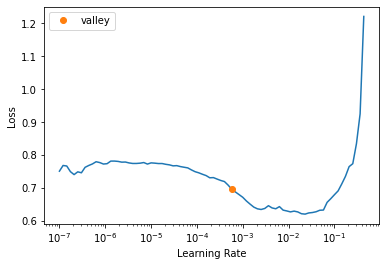

In [107]:
cat_learn.lr_find()

#### Check params of unet before and after

In [112]:
encoder = timm.create_model('efficientnet_b0', pretrained=True)
unet = DynamicTimmUnet(encoder, n_out=3, img_size=(224, 224))

In [113]:
params(encoder)[0][0]

tensor([[[ 0.1216,  0.6563,  0.4567],
         [-0.1109, -0.6100, -0.3334],
         [ 0.0280, -0.1031, -0.1032]],

        [[ 0.0636,  1.6552,  1.7436],
         [-0.1365, -1.5367, -1.5937],
         [ 0.0502, -0.1136, -0.1260]],

        [[ 0.0873,  0.3613,  0.2695],
         [-0.1197, -0.2812, -0.2188],
         [ 0.0367, -0.0708, -0.0819]]], grad_fn=<SelectBackward0>)

In [110]:
params(unet)[0][0]

tensor([[[ 0.1216,  0.6563,  0.4567],
         [-0.1109, -0.6100, -0.3334],
         [ 0.0280, -0.1031, -0.1032]],

        [[ 0.0636,  1.6552,  1.7436],
         [-0.1365, -1.5367, -1.5937],
         [ 0.0502, -0.1136, -0.1260]],

        [[ 0.0873,  0.3613,  0.2695],
         [-0.1197, -0.2812, -0.2188],
         [ 0.0367, -0.0708, -0.0819]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [111]:
set_seed(SEED, True)
cat_dls = db.dataloaders(dev, bs=16, shuffle=True)

In [114]:
body = nn.Sequential(*encoder.children())[:-2]
head = create_head(1280, 3)
cat_model = CatModel(body, head)

In [115]:
cat_learn = Learner(cat_dls, cat_model, BCEWithLogitsLossFlat(), splitter=splitter, metrics=accuracy_multi)

In [116]:
cat_learn.fine_tune(1, 1e-3)

In [135]:
params(unet)[4] == params(cat_learn.model)[4]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True], device='cuda:0')

## Test removing true empty positives from metrics

### Control

In [17]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [18]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [19]:
learn.fit_one_cycle(3, 2e-2)

In [33]:
def dice_coeff(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        inp_i, targ_i, dice_i = inp[i], targ[i], []
        for j in range(targ.shape[1]):
            inp_ij, targ_ij = inp_i[j], targ_i[j]
            if inp_ij.sum() == targ_ij.sum() == 0:
                continue
            I = (targ_ij * inp_ij).sum()
            U =  targ_ij.sum() + inp_ij.sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    return np.mean(dice_scores)

In [28]:
def hd_dist(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    return np.mean(hd_scores)

In [34]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [35]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [36]:
learn.fit_one_cycle(3, 2e-2)

## Test conditionals in metrics

### Regular metrics

In [16]:
dls, dev = get_aug_dls(train, aug_transforms(), sample=True, sample_empty=True, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [ ]:
learn.fit_flat_cos(2, 1e-2)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


### New metrics

In [16]:
def dice_coeff(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    if targ.sum() == 0:
        if inp.sum() == 0:
            return 1
        else:
            return 0
    eps = 1e-5
    I = (targ * inp).sum((2, 3))
    U =  targ.sum((2,3)) + inp.sum((2, 3))
    return ((2.*I+eps)/(U+eps)).mean((1, 0))


def hd_dist_per_slice(inp, targ):
    if targ.sum() == 0:
        if inp.sum() == 0:
            return 1
        else:
            return 0
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

In [17]:
dls, dev = get_aug_dls(train, aug_transforms(), sample=True, sample_empty=True, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [18]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [19]:
learn.fit_flat_cos(2, 1e-2)

## Test dropping empty masks from training data

In [16]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=True, sample_empty=True, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

In [19]:
learn.fit_flat_cos(10, 2e-2)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


## Test group case validation score over efficientnet sample baseline

In [16]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=True, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

SuggestedLRs(valley=0.005248074419796467)

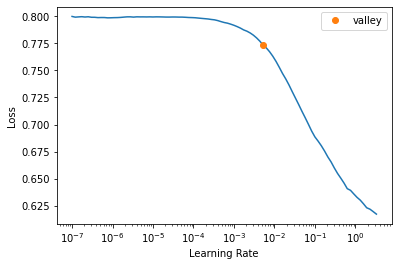

In [18]:
learn.lr_find()

In [19]:
learn.fit_flat_cos(10, 2e-2)

The score has decreased, which means that I probably should use it over custom validation as it is more similar to the public LB.

## Use custom albumentations augmentation

In [20]:
import albumentations

In [83]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [94]:
def get_train_aug(): return albumentations.Compose([
            # albumentations.RandomResizedCrop(224,224),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            # albumentations.HueSaturationValue(
            #     hue_shift_limit=0.2, 
            #     sat_shift_limit=0.2, 
            #     val_shift_limit=0.2, 
            #     p=0.5),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(): return albumentations.Compose([
    albumentations.CenterCrop(224,224, p=1.),
    albumentations.Resize(224,224),
    albumentations.CoarseDropout(p=0.5)
], p=1.)

In [95]:
tfms = [[get_image, PILImageBW.create], [get_mask, PILMask.create]]
splits = ColSplitter()(train)
dsets = Datasets(train, tfms, splits=splits)
dls = dsets.dataloaders(bs=16, after_item=[Resize(224),
                                           SegmentationAlbumentationsTransform(get_train_aug(), 0),
                                           SegmentationAlbumentationsTransform(get_valid_aug(), 1),
                                           ToTensor()])

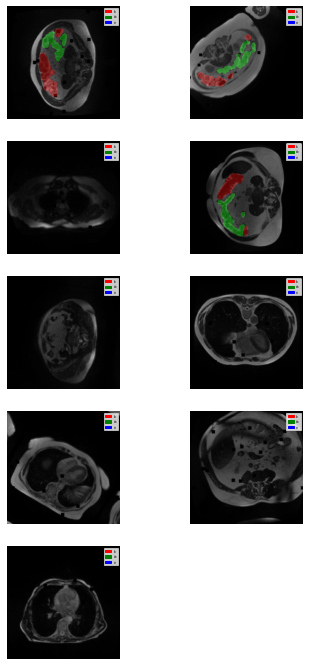

In [96]:
dls.show_batch()

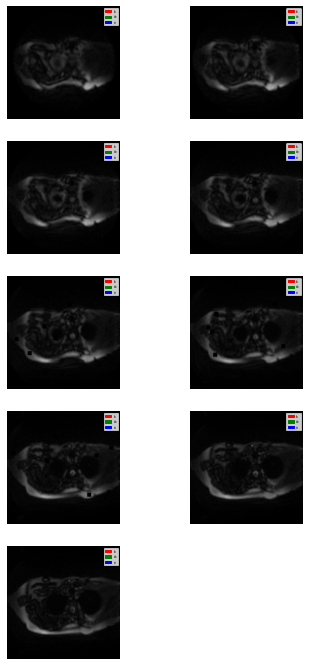

In [97]:
dls.valid.show_batch()

In [60]:
db = DataBlock((ImageBlock(cls=PILImageBW), MaskBlock),
               get_x=get_image,
               get_y=get_mask,
               splitter = ColSplitter(),
               item_tfms=[Resize(224, method='squish'), AlbumentationsTransform(get_train_aug(), get_valid_aug())],
               batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [61]:
dls = db.dataloaders(train, bs=16)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


AttributeError: 'AlbumentationsTransform' object has no attribute 'aug'

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


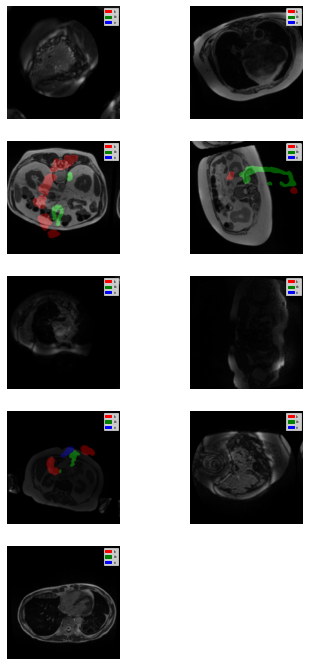

In [57]:
dls.show_batch();

## Test segmentation pytorch unet model 

My models are still underperforming on the kaggle leaderboard, so I'll try using segmentation models library to compare it with the fastai's one. 

In [36]:
unet = build_model('resnet34')

In [37]:
dls, dev = get_aug_dls(aug_transforms(), sample=False, bs=16, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [38]:
def splitter(model):
    return [params(model.encoder), params(model.decoder)]

In [39]:
learn = Learner(dls, unet, metrics=[dice_coeff, hd_dist, custom_metric], loss_func=DiceBCELoss(), splitter=splitter).to_fp16()

In [40]:
learn.freeze()

SuggestedLRs(valley=0.005248074419796467)

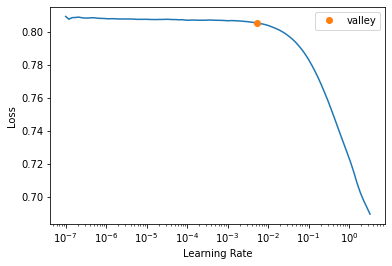

In [41]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(5, 0.03)

SuggestedLRs(valley=7.585775892948732e-05)

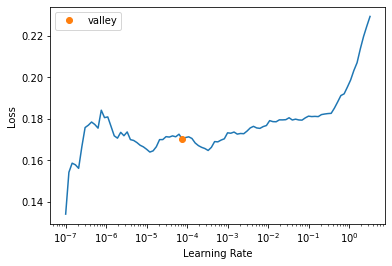

In [43]:
learn.unfreeze()
learn.lr_find()

In [45]:
learn.export('models/round4-model.pkl')

In [44]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

KeyboardInterrupt: 

In [74]:
learn.export('models/round4-model.pkl')

### Compare fastai's unet learner with the same configuration but instantiate a dynamic unet instead

In [116]:
fastai_unet = create_unet_model(models.resnet34, 3, (224 ,224), True, n_in=3)

In [117]:
fastai_learn = Learner(dls, fastai_unet, metrics=[dice_coeff, hd_dist, custom_metric], loss_func=DiceBCELoss()).to_fp16()

In [118]:
fastai_learn.freeze()

In [ ]:
fastai_learn.fit_one_cycle(5, 3e-3)

It is obvious now that fastai's unet implementation is slower than smp's. That's probably why using efficientnet with fastai's unet model results in slow models. I'll compare them right after.

In [ ]:
fastai_learn.unfreeze()

In [ ]:
fastai_learn.fit_one_cycle(10, slice(1e-6, 1e-4))

In [ ]:
learn.export('round2-fastai-model.pkl')

### Test smp efficientnet

In [ ]:
unet = build_model('efficientnet-b0')

In [ ]:
learn = Learner(dls, unet, metrics=[dice_coeff, hd_dist, custom_metric], loss_func=DiceBCELoss()).to_fp16()

In [ ]:
learn.freeze()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr/400, lr/10))

In [ ]:
learn.export('round3-model.pkl')

## Test my dice loss againt smp dice loss

### Create a datalaoder

In [76]:
dls, dev = get_aug_dls(aug_transforms(), sample=True, bs=16, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


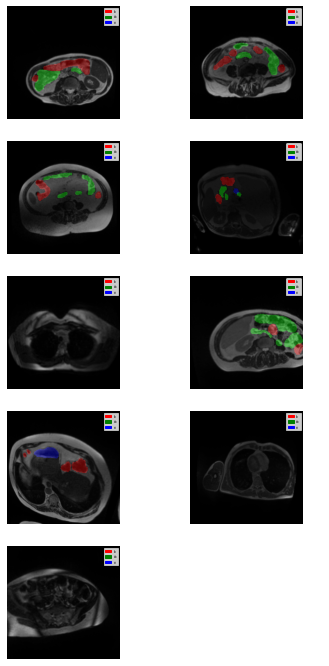

In [77]:
dls.show_batch()

In [78]:
set_seed(SEED, True)
learn = unet_learner(dls, resnet34, metrics=[mod_acc, dice_coeff, hd_dist, custom_metric], n_out=3, loss_func=DiceLossMulti()).to_fp16()

In [79]:
def compare_losses(learn):
    smp_loss = smp.losses.DiceLoss('multilabel', from_logits=False)
    my_loss = DiceLossModule(eps=1e-07, from_logits=False)
    
    b = learn.dls.one_batch()
    preds, targs = learn.get_preds(dl=[b])
            
    print(my_loss(preds, targs), smp_loss(preds, targs))


In [80]:
compare_losses(learn)

TensorMask(2.0147) TensorMask(0.9952)


#### Let's train for a while an compare losses afterwards

SuggestedLRs(valley=0.00010964782268274575)

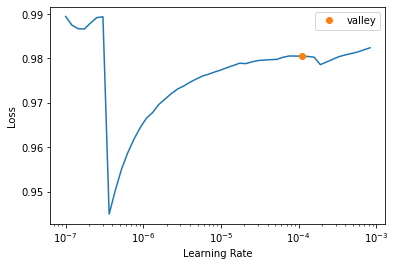

In [81]:
learn.freeze()
learn.lr_find()

In [131]:
learn.fit_one_cycle(3, slice(1e-4))

In [133]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4/400, 1e-4/10))

In [231]:
compare_losses(learn)

TensorMask(0.4833) TensorMask(0.4154)


#### They seem to be similar now so I'll move to something else

## Test resize squish vs pad

### Create a new validation dl without any transformation

In [ ]:
raw_dl = dls.valid.new(after_item=[ToTensor], after_batch=[], bs=1)

### Get all predictions

In [63]:
imgs, preds, targs = learn.get_preds(dl=dls.valid, with_input=True)

KeyboardInterrupt: 

### Convert predictions to numpy masks

In [ ]:
preds_masks = (sigmoid(preds) > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

### Upsize predicted masks 

In [346]:
from tqdm import tqdm
import cv2

In [347]:
before_dices = []
after_dices = []
org_imgs = []
inp_masks = []
targ_masks = []
val = dev.query('is_valid')
for pred_mask, pred, targ, raw_b, width, height in tqdm(zip(preds_masks, preds, targs, raw_dl, val['slice_w'], val['slice_h'])):
    upsized_mask = np.moveaxis(cv2.resize(pred_mask, dsize=(height, width), interpolation=cv2.INTER_NEAREST), -1, 0)
    targ_mask = raw_b[1]
    
    before_dices.append(dice_coeff(pred[None, ...], targ[None, ...]))
    after_dices.append(dice_coeff(upsized_mask[None, ...], targ_mask/255))
    org_imgs.append(raw_b[0])
    inp_masks.append(upsized_mask)
    targ_masks.append(targ_mask)

1618it [00:42, 37.82it/s]


In [348]:
np.mean(before_dices), np.mean(after_dices)

(0.16694807994052036, 0.16581764161185739)

## Exploration

In [21]:
train.head()

id  \
0  case101_day20_slice_0001   
1  case101_day20_slice_0002   
2  case101_day20_slice_0003   
3  case101_day20_slice_0004   
4  case101_day20_slice_0005   

                                                                fname  \
0  train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png   
1  train/case101/case101_day20/scans/slice_0002_266_266_1.50_1.50.png   
2  train/case101/case101_day20/scans/slice_0003_266_266_1.50_1.50.png   
3  train/case101/case101_day20/scans/slice_0004_266_266_1.50_1.50.png   
4  train/case101/case101_day20/scans/slice_0005_266_266_1.50_1.50.png   

                                                                                                                                                                                                         fnames  \
0  [train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0003_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0005_266_266_1.50_1.50.png]   
1  [train/case101/case101_day20/scans/slice_0002_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0004_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0006_266_266_1.50_1.50.png]   
2  [train/case101/case101_day20/scans/slice_0003_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0005_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0007_266_266_1.50_1.50.png]   
3  [train/case101/case101_day20/scans/slice_0004_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0006_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0008_266_266_1.50_1.50.png]   
4  [train/case101/case101_day20/scans/slice_0005_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0007_266_266_1.50_1.50.png, train/case101/case101_day20/scans/slice_0009_266_266_1.50_1.50.png]   

   n_segs lb_seg_rle  lb_seg_flag sb_seg_rle  sb_seg_flag st_seg_rle  \
0       0        NaN        False        NaN        False        NaN   
1       0        NaN        False        NaN        False        NaN   
2       0        NaN        False        NaN        False        NaN   
3       0        NaN        False        NaN        False        NaN   
4       0        NaN        False        NaN        False        NaN   

   st_seg_flag  slice_h  slice_w  px_spacing_h  px_spacing_w case_id_str  \
0        False      266      266           1.5           1.5     case101   
1        False      266      266           1.5           1.5     case101   
2        False      266      266           1.5           1.5     case101   
3        False      266      266           1.5           1.5     case101   
4        False      266      266           1.5           1.5     case101   

   case_id day_num_str  day_num case_id_day_num_str    slice_id  
0      101       day20       20       case101_day20  slice_0001  
1      101       day20       20       case101_day20  slice_0002  
2      101       day20       20       case101_day20  slice_0003  
3      101       day20       20       case101_day20  slice_0004  
4      101       day20       20       case101_day20  slice_0005

### What is the average number of segments?

In [53]:
train.n_segs.mean()

0.8809486699916874

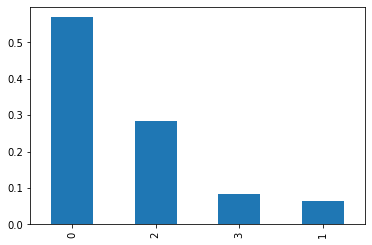

In [24]:
(train.n_segs.value_counts()/train.shape[0]).plot(kind='bar');

More than 50% of the training data doesn't have segmentations.

### What is the most under segmented organ?

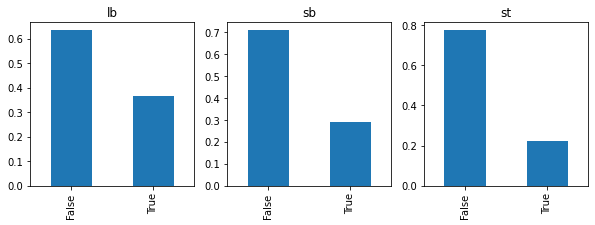

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

(train.lb_seg_flag.value_counts()/train.shape[0]).plot(kind='bar', ax=axes[0], title='lb');
(train.sb_seg_flag.value_counts()/train.shape[0]).plot(kind='bar', ax=axes[1], title='sb');
(train.st_seg_flag.value_counts()/train.shape[0]).plot(kind='bar', ax=axes[2], title='st');

Stomach is the least segmented organ, followed by small bowel then large bowel.

### What is the average voxel count per organ?

In [72]:
def get_gt_count(rle):
    if isinstance(rle, str):
        return np.sum([int(x) for i, x in enumerate(rle.split(' '), 1) if i % 2 == 0])
    else:
        return 0

In [73]:
train['lb_seg_count'] = train.lb_seg_rle.apply(get_gt_count)
train['sb_seg_count'] = train.sb_seg_rle.apply(get_gt_count)
train['st_seg_count'] = train.st_seg_rle.apply(get_gt_count)

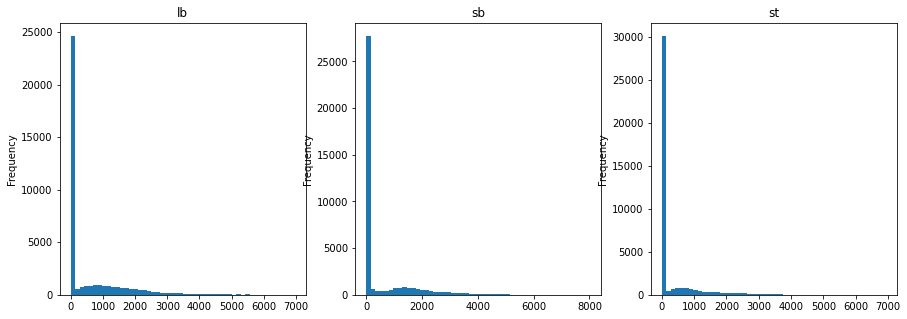

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

train.lb_seg_count.plot(kind='hist', bins=50, ax=axes[0], title='lb');
train.sb_seg_count.plot(kind='hist', bins=50, ax=axes[1], title='sb');
train.st_seg_count.plot(kind='hist', bins=50, ax=axes[2], title='st');

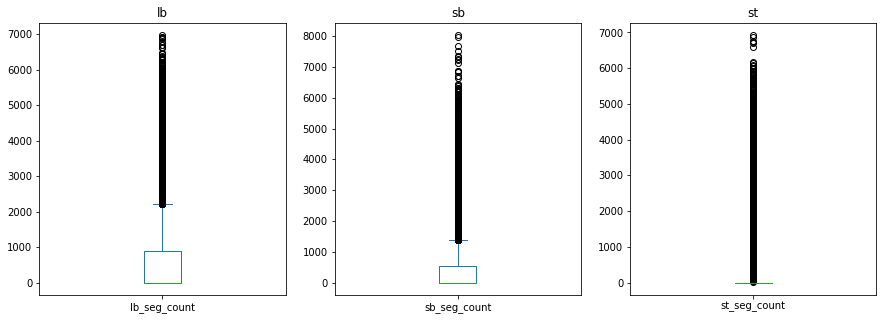

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

train.lb_seg_count.plot(kind='box', ax=axes[0], title='lb');
train.sb_seg_count.plot(kind='box', ax=axes[1], title='sb');
train.st_seg_count.plot(kind='box', ax=axes[2], title='st');

In [79]:
train.lb_seg_count.mean(), train.sb_seg_count.mean(), train.st_seg_count.mean()

(569.7625207813799, 521.6272339983375, 288.9091593931837)

### What is the mean proportion of gt for each organ?

In [84]:
train.pixels_count = train.slice_w * train.slice_h

/tmp/ipykernel_12014/3779868491.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train.pixels_count = train.slice_w * train.slice_h


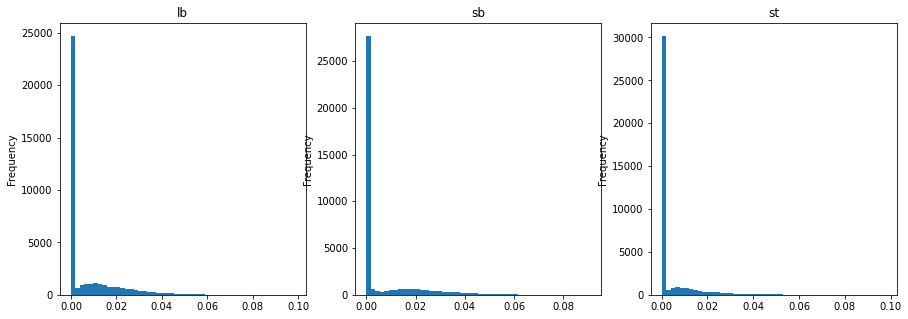

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

(train.lb_seg_count/train.pixels_count).plot(kind='hist', bins=50, ax=axes[0], title='lb');
(train.sb_seg_count/train.pixels_count).plot(kind='hist', bins=50, ax=axes[1], title='sb');
(train.st_seg_count/train.pixels_count).plot(kind='hist', bins=50, ax=axes[2], title='st');

In [91]:
(train.lb_seg_count/train.pixels_count).mean(), (train.sb_seg_count/train.pixels_count).mean(), (train.st_seg_count/train.pixels_count).mean()

(0.007031095071937798, 0.006466719201663856, 0.003631339195790701)

### What is the minimum proportion for each organ above 0?

In [92]:
train['lb_seg_prop'] = train.lb_seg_count/train.pixels_count
train['sb_seg_prop'] = train.sb_seg_count/train.pixels_count
train['st_seg_prop'] = train.st_seg_count/train.pixels_count

In [99]:
train.loc[train['lb_seg_prop'] != 0, 'lb_seg_prop'].min(), train.loc[train['sb_seg_prop'] != 0, 'sb_seg_prop'].min(), train.loc[train['st_seg_prop'] != 0, 'st_seg_prop'].min()

(9.85663082437276e-05, 0.0003225806451612903, 0.00016959692464243314)

### What is the most common height and width?

In [106]:
train.groupby(['slice_w', 'slice_h']).size()

slice_w  slice_h
234      234          144
266      266        25920
276      276         1200
310      360        11232
dtype: int64

### What is the mean number of segments per height and width?

In [109]:
train.groupby(['slice_w', 'slice_h'])['n_segs'].describe()

count     mean       std  min  25%  50%   75%  max
slice_w slice_h                                                      
234     234        144.0  0.81250  1.164563  0.0  0.0  0.0  1.25  3.0
266     266      25920.0  0.86142  1.078504  0.0  0.0  0.0  2.00  3.0
276     276       1200.0  1.29750  1.146046  0.0  0.0  2.0  2.00  3.0
310     360      11232.0  0.88239  1.073791  0.0  0.0  0.0  2.00  3.0

### What is the proportion of organ ground truth per image size?

In [110]:
train.groupby(['slice_w', 'slice_h'])['lb_seg_prop'].describe()

count      mean       std  min  25%       50%       75%  \
slice_w slice_h                                                              
234     234        144.0  0.006315  0.013408  0.0  0.0  0.000000  0.000000   
266     266      25920.0  0.007374  0.013155  0.0  0.0  0.000000  0.011363   
276     276       1200.0  0.009755  0.012794  0.0  0.0  0.003453  0.016150   
310     360      11232.0  0.005958  0.010341  0.0  0.0  0.000000  0.009391   

                      max  
slice_w slice_h            
234     234      0.053528  
266     266      0.098423  
276     276      0.050856  
310     360      0.057258

In [111]:
train.groupby(['slice_w', 'slice_h'])['sb_seg_prop'].describe()

count      mean       std  min  25%  50%       75%  \
slice_w slice_h                                                         
234     234        144.0  0.004470  0.009068  0.0  0.0  0.0  0.000228   
266     266      25920.0  0.006884  0.013479  0.0  0.0  0.0  0.006900   
276     276       1200.0  0.008862  0.015386  0.0  0.0  0.0  0.013567   
310     360      11232.0  0.005273  0.010505  0.0  0.0  0.0  0.005146   

                      max  
slice_w slice_h            
234     234      0.032727  
266     266      0.090918  
276     276      0.074853  
310     360      0.071909

In [112]:
train.groupby(['slice_w', 'slice_h'])['st_seg_prop'].describe()

count      mean       std  min  25%  50%       75%  \
slice_w slice_h                                                         
234     234        144.0  0.002208  0.003897  0.0  0.0  0.0  0.003484   
266     266      25920.0  0.003969  0.010046  0.0  0.0  0.0  0.000000   
276     276       1200.0  0.006082  0.011591  0.0  0.0  0.0  0.008044   
310     360      11232.0  0.002608  0.006673  0.0  0.0  0.0  0.000000   

                      max  
slice_w slice_h            
234     234      0.015670  
266     266      0.097758  
276     276      0.066858  
310     360      0.054247

246x276 images always have the highest average proportion for all organs, followed by 266x266 images.

However, the max proportion is in 266x266 also for all organs.

### How many cases are there?

In [114]:
train['case_id'].nunique()

85

### How many days per case are there?

In [119]:
train.groupby('case_id')['day_num'].nunique().mean()

3.223529411764706

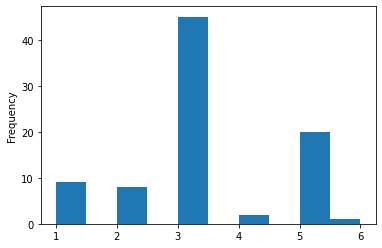

In [118]:
train.groupby('case_id')['day_num'].nunique().plot(kind='hist');

### How many slices per day are there?

In [135]:
train.groupby(['case_id', 'day_num'])['slice_id'].nunique().unique()

array([144,  80])

So it's either 144 or 80.

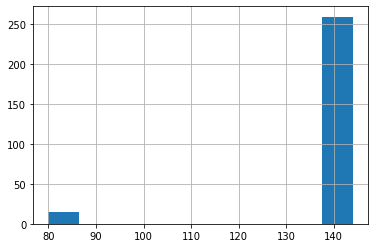

In [137]:
train.groupby(['case_id', 'day_num'])['slice_id'].nunique().hist();

And the majority is 140.

### What are the days present?

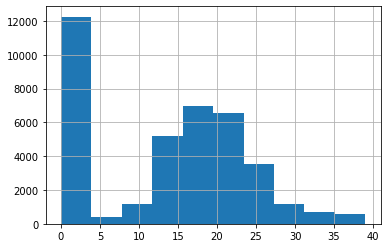

In [142]:
train.day_num.hist(bins=10);

It seems that they are normally distributed, but there is a mode at 0. Which means that there is a large number of cases that only have day 0.

In [145]:
day_0 = train.query('day_num == 0')

In [147]:
day_0.case_id.nunique()

82

No, it actually meant that nearly all cases have day 0.

In [151]:
train.query('day_num == 20').case_id.nunique()

19

### Which slices have no segments?

In [169]:
train['slice_no'] = train['slice_id'].apply(lambda x: int(x.split('_')[1].lstrip('0')))

In [170]:
train['has_segs'] = (train['n_segs'] > 0).astype(int)

In [200]:
train['lb_seg_flag'] = train['lb_seg_flag'].astype(int)
train['sb_seg_flag'] = train['sb_seg_flag'].astype(int)
train['st_seg_flag'] = train['st_seg_flag'].astype(int)

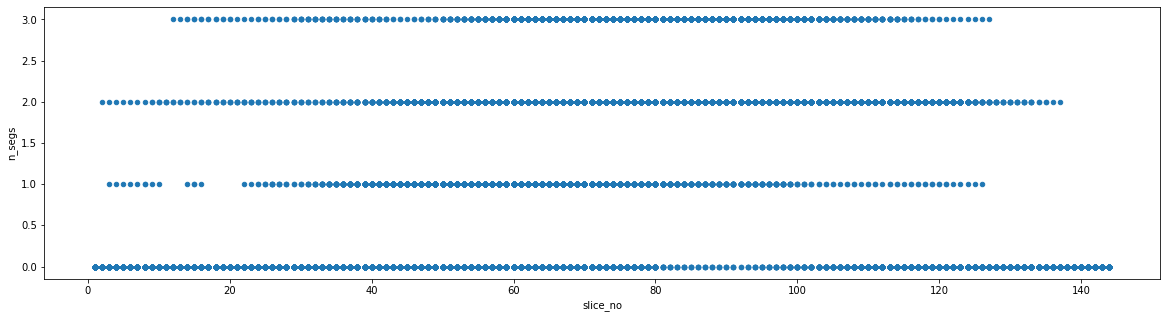

In [204]:
train.plot(kind='scatter', x='slice_no', y='n_segs', figsize=(20, 5));

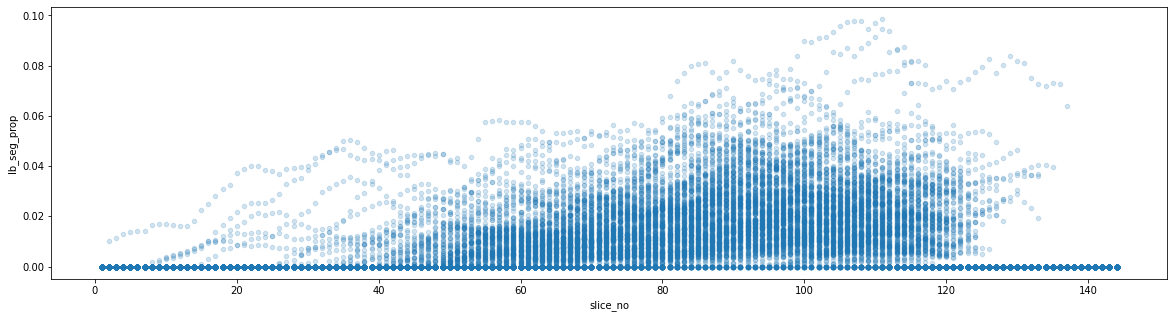

In [211]:
train.plot(kind='scatter', x='slice_no', y='lb_seg_prop', alpha=0.2, figsize=(20, 5));

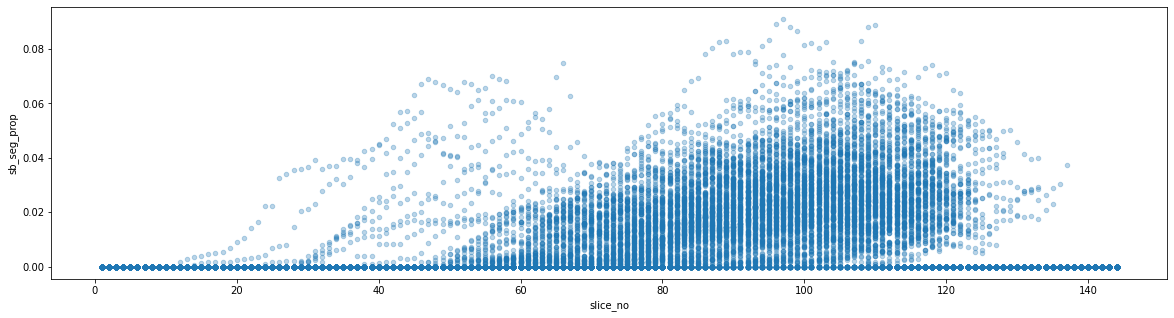

In [212]:
train.plot(kind='scatter', x='slice_no', y='sb_seg_prop', alpha=0.3, figsize=(20, 5));

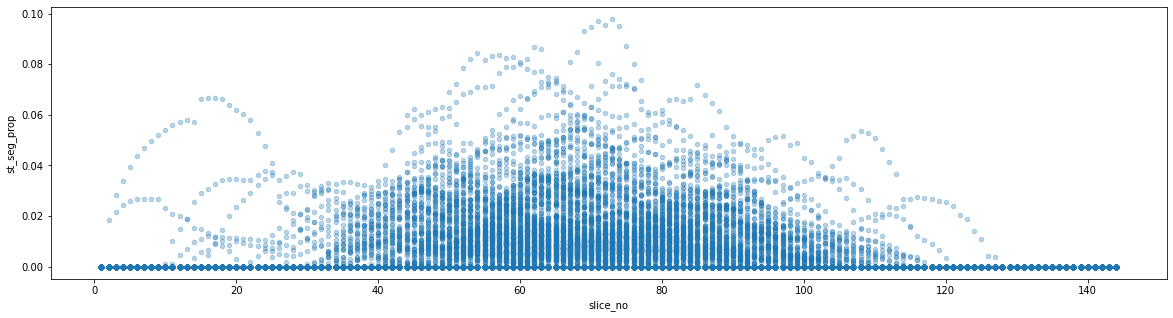

In [213]:
train.plot(kind='scatter', x='slice_no', y='st_seg_prop', alpha=0.3, figsize=(20, 5));

We can see that the proportion moves per slice level, so it would be better to post process the predictions using the mean proportion of the current day.

In [220]:
tmp = train.groupby('slice_no')['lb_seg_flag'].value_counts().unstack()
tmp[tmp[0].notnull() & tmp[1].isna()]

lb_seg_flag      0   1
slice_no              
1            274.0 NaN
138          259.0 NaN
139          259.0 NaN
140          259.0 NaN
141          259.0 NaN
142          259.0 NaN
143          259.0 NaN
144          259.0 NaN

In [221]:
tmp = train.groupby('slice_no')['sb_seg_flag'].value_counts().unstack()
tmp[tmp[0].notnull() & tmp[1].isna()]

sb_seg_flag      0   1
slice_no              
1            274.0 NaN
2            274.0 NaN
3            274.0 NaN
4            274.0 NaN
5            274.0 NaN
6            274.0 NaN
7            274.0 NaN
8            274.0 NaN
9            274.0 NaN
10           274.0 NaN
11           274.0 NaN
138          259.0 NaN
139          259.0 NaN
140          259.0 NaN
141          259.0 NaN
142          259.0 NaN
143          259.0 NaN
144          259.0 NaN

In [222]:
tmp = train.groupby('slice_no')['st_seg_flag'].value_counts().unstack()
tmp[tmp[0].notnull() & tmp[1].isna()]

st_seg_flag      0   1
slice_no              
1            274.0 NaN
128          259.0 NaN
129          259.0 NaN
130          259.0 NaN
131          259.0 NaN
132          259.0 NaN
133          259.0 NaN
134          259.0 NaN
135          259.0 NaN
136          259.0 NaN
137          259.0 NaN
138          259.0 NaN
139          259.0 NaN
140          259.0 NaN
141          259.0 NaN
142          259.0 NaN
143          259.0 NaN
144          259.0 NaN

In [224]:
train.groupby('slice_no')[['lb_seg_prop', 'sb_seg_prop', 'st_seg_prop']].mean().iloc[50:60]

lb_seg_prop  sb_seg_prop  st_seg_prop
slice_no                                       
51           0.002987     0.001268     0.007393
52           0.003243     0.001408     0.007932
53           0.003616     0.001506     0.008182
54           0.003965     0.001601     0.008404
55           0.004372     0.001791     0.008747
56           0.004755     0.001966     0.009147
57           0.005101     0.001885     0.009551
58           0.005510     0.002020     0.010017
59           0.005825     0.001931     0.010486
60           0.006218     0.002085     0.010792

In [225]:
train[['lb_seg_prop', 'sb_seg_prop', 'st_seg_prop']].mean()

lb_seg_prop    0.007031
sb_seg_prop    0.006467
st_seg_prop    0.003631
dtype: float64